# Cluster the data 

In [13]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
#adata = sc.read('/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg.h5ad')
adata = sc.read('/storage/users/data/PANC/H5AD_file/IV_adata_filtered_no2D_hvg.h5ad')

In [15]:
adata

AnnData object with n_obs × n_vars = 5257 × 2000
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'condition_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Dimension reduction and Clustering

### Calculate DR & Clustering

In [16]:
# prepre clustering
#sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver="arpack") # PCA
sc.pp.neighbors(adata, n_neighbors=8, n_pcs=40) # Neighborhood Graph Construction

In [17]:
sc.tl.umap(adata)
sc.tl.leiden(adata)

### Visualize DR

In [18]:
!pwd

/home/s468630/Projects/scAnalysis


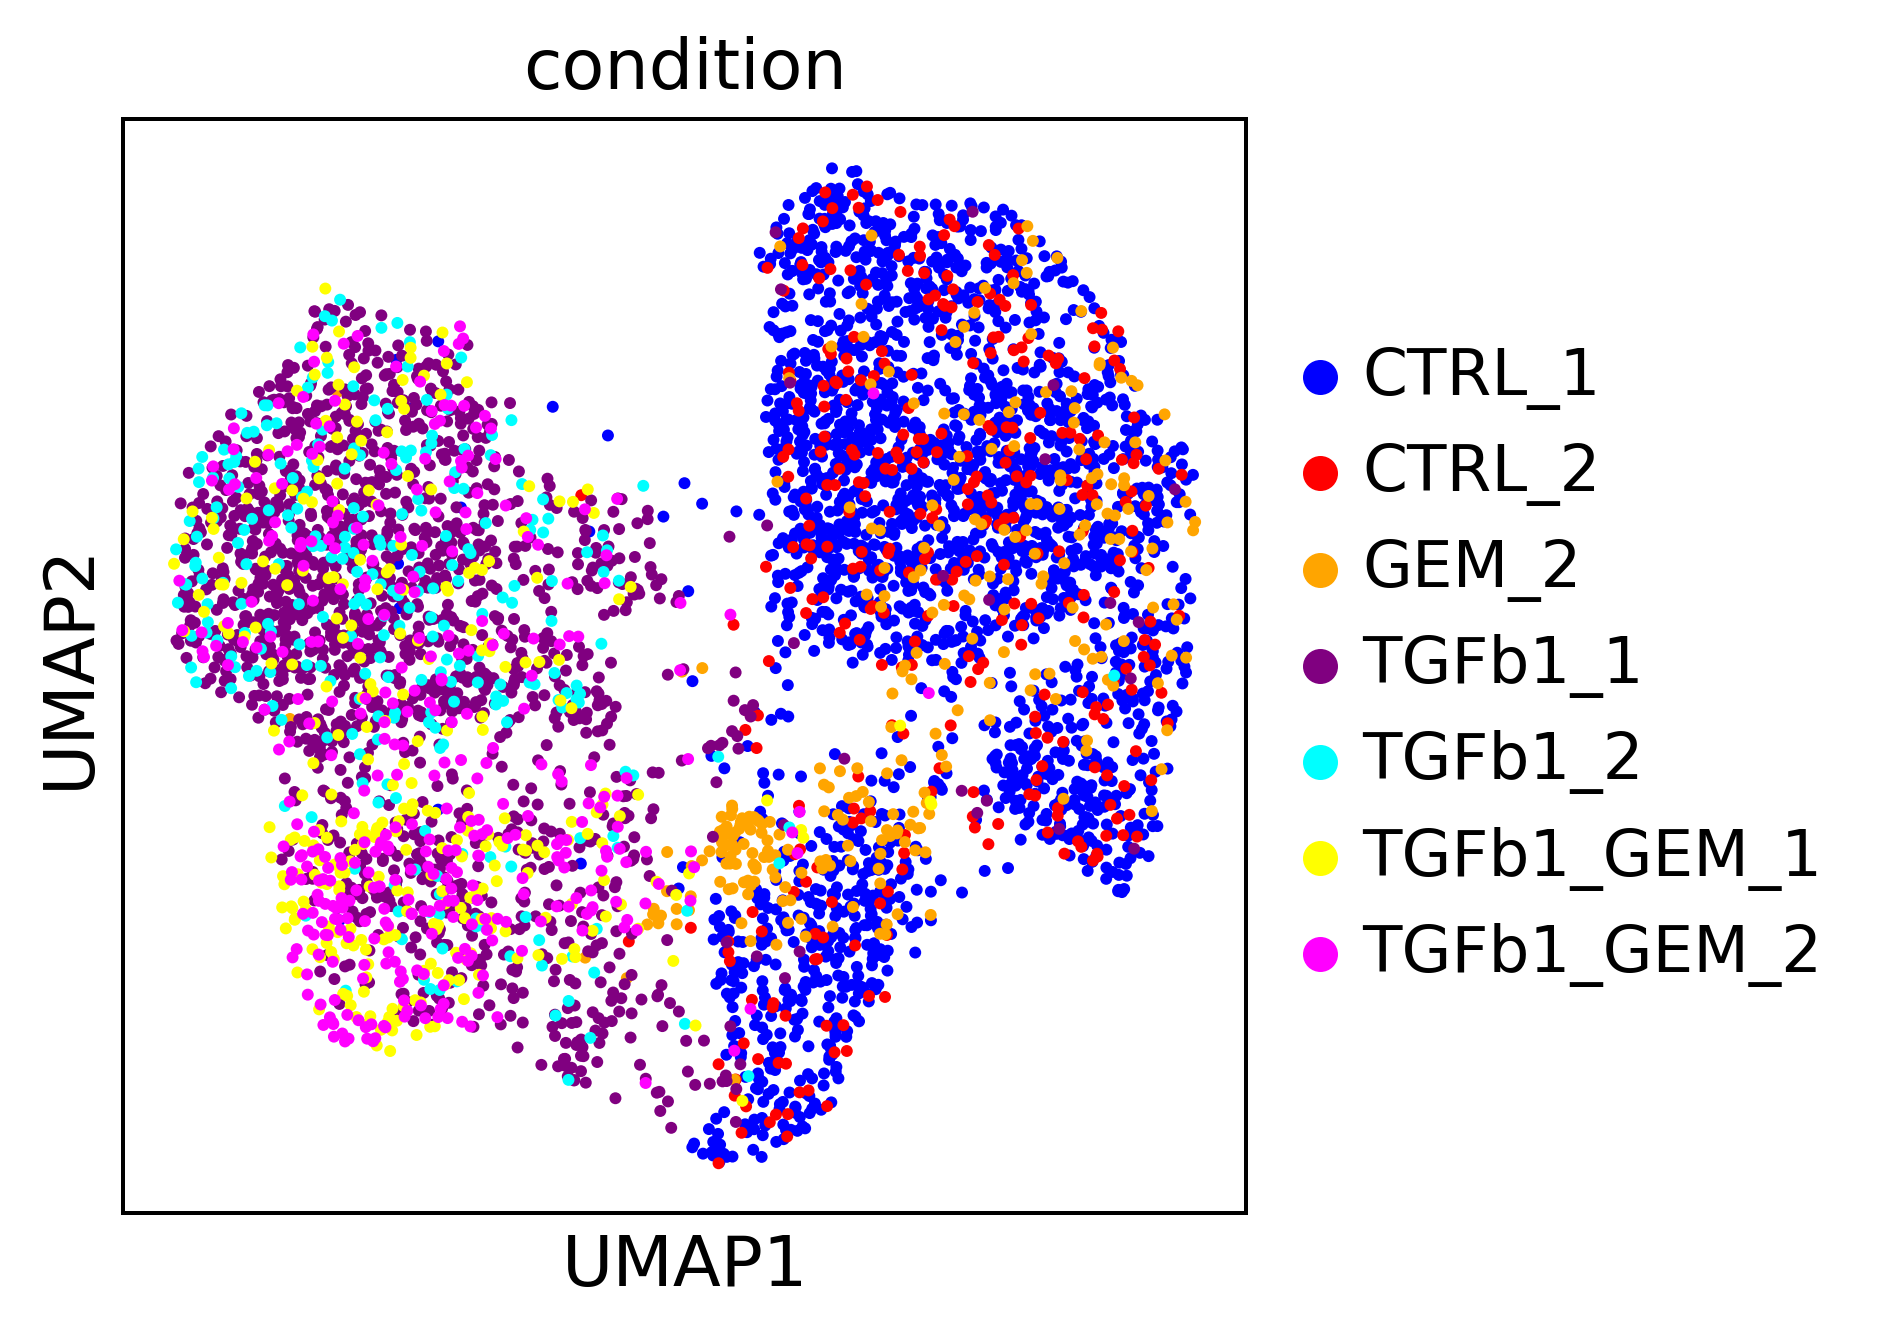

In [22]:
# Predefined condition-to-color mapping
condition_colors = {
    'CTRL_1': 'blue',
    'CTRL_2': 'red',
    'GEM_2': 'orange',
    'TGFb1_1': 'purple',
    'TGFb1_2': 'cyan',
    'TGFb1_GEM_1': 'yellow',
    'TGFb1_GEM_2': 'magenta'
}

# Ensure all conditions in adata.obs['condition'] have a color mapping
conditions = adata.obs['condition'].unique()
missing_conditions = set(conditions) - set(condition_colors.keys())
if missing_conditions:
    raise ValueError(f"Color mapping missing for conditions: {missing_conditions}")

# Plot the UMAP with the predefined colors
sc.settings.set_figure_params(dpi=180, dpi_save=300)
sc.pl.umap(
    adata,
    color=['condition'],
    legend_loc='right margin',
    palette=condition_colors,
    save="_UMAP_cond_preprocessing.png"
)

Found 5 clusters with resolution: 0.15


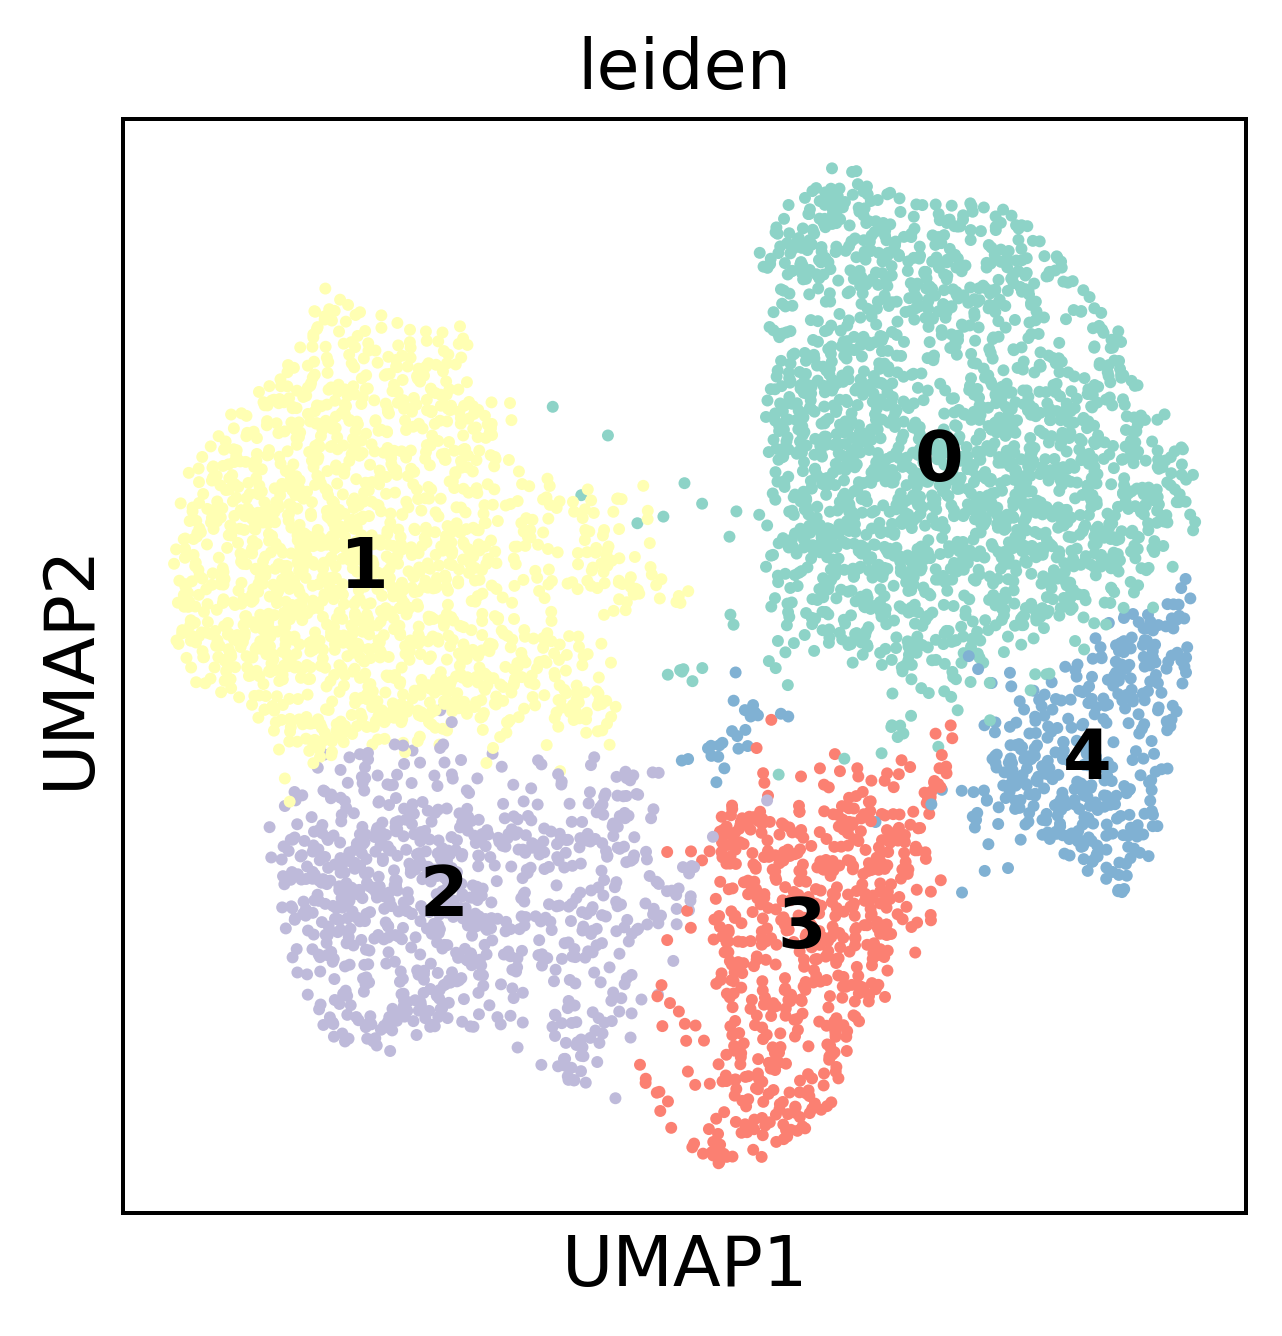

In [23]:
# Initialize variables
found = False
max_resolution = 1.0  # Maximum resolution to try
step_size = 0.01      # Step size for resolution
max_iterations = int(max_resolution / step_size)  # Calculate maximum iterations

# Iterate through Leiden resolutions to find 7 clusters
for i in range(max_iterations):
    resolution = step_size * (i + 1)  # Compute resolution
    sc.tl.leiden(adata, resolution=resolution)  # Perform Leiden clustering
    n_clusters = adata.obs['leiden'].nunique()  # Count unique clusters

    if n_clusters == 5:
        print(f"Found 5 clusters with resolution: {resolution}")
        found = True
        break  # Stop iteration once the desired number of clusters is found

# Stop condition handling
if not found:
    print(f"Could not find 5 clusters within resolution up to {max_resolution}.")
else:
    # Define a color palette for the clusters
    leiden_clusters = adata.obs['leiden']
    color_palette = sns.color_palette('Set3', n_clusters)

    # Visualize the UMAP with Leiden clustering
    sc.pl.umap(
        adata,
        color='leiden',
        palette=color_palette,
        legend_loc='on data',
        save=f"_UMAP_leiden_{resolution:.2f}_clusters.png"
    )

## Export

In [21]:
adata.write("/storage/users/data/PANC/H5AD_file/IV_adata_filtered_no2D_hvg_clust.h5ad")